<a href="https://colab.research.google.com/github/YonggunJung/Project1-KOSPI/blob/main/kospi_%EC%96%91%EB%B0%A9%ED%96%A5LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

# 경고 뜨지 않게..
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

# 랜덤 모듈
import random

# 학습 모델 저장 및 복원
import pickle

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation
# CNN : 커널을 통해 합성곱을 구하는 것, 이미지의 특징이 두드러지게 한다.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
# MaxPooling : 커널내에서 가장 큰 값을 추출하는 방식으로 불필요한 부분을 제거한다., 값이 작은부분은 빠져버린다
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool1D
# Flatten : 다차원의 이미지 데이터를 선형회귀 은닉층으로 전달하기 전에
# 1차원으로 변환하는것
from tensorflow.keras.layers import Flatten
# Dropout : 이미지나 영상, 음파등의 데이터는 오랫동안 학습을 진행 시켜야 한다.
# 하지만 너무 빨리 과적합이 발생되면 조기 중단 때문에 학습 횟수가 줄어들 수 있다.
# 이에 은닉의 노드를 일부 사용하지 않으므로써 과적합이 빨리 오는것을 예방하고
# 오랫동안 학습이 진행될 수있도록한다
from tensorflow.keras.layers import Dropout
# Embedding : 단어의 수를 조정한다.
from tensorflow.keras.layers import Embedding

# LSTM
from tensorflow.keras.layers import LSTM


from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional



# 원핫 인코딩을 수행하는 함수
from tensorflow.keras.utils import to_categorical

# 저장된 학습 모델을 복원한다.
from tensorflow.keras.models import load_model

# 모델을 자동 저장한다.
from tensorflow.keras.callbacks import ModelCheckpoint

# 성능이 더이상 좋아지지 않을 경우 중단 시킨다.
from tensorflow.keras.callbacks import EarlyStopping

# 문장을 잘라준다.
from tensorflow.keras.preprocessing.text import Tokenizer
# 모든 문장 데이터의 단어 데이터의 수를 동일한 수로 맞춰준다.
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 문자열을 가지고 단어 사전을 만들어준다.
from tensorflow.keras.preprocessing.text import text_to_word_sequence


# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# 문자열 -> 숫자
from sklearn.preprocessing import LabelEncoder

# 전체데이터를 학습용과 검증으로 나눈다.
from sklearn.model_selection import train_test_split

# 랜덤시드 설정
# 데이터를 랜덤하게 섞거나 가중치를 랜덤하게 설정하는 등..
# 작업에서 랜덤을 적용하는 경우가 더러 있다.
# 이에, 시드를 고정시킨다.
random_seed = 1

np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

# 현재 프로젝트에서 GPU 메모리 사용을 필요한 만큼만 쓸 수 있도록 한다.
# 컴퓨터에 있는 GPU 정보들을 가져온다.
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu가 있다면...
if len(gpus) > 0 :
    try :
        for gpu in gpus :
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e :
        print(e)

from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [ ]:
# 데이터를 읽어온다.
cell = pd.read_csv('./data/코스피상관관계1 월별.csv')
cell

,Unnamed: 0,일자,코스피,코스피200,S&P500,금값,나스닥,넷플릭스,물가지수,상해종합,...,국고채(3년),"회사채(3년, AA-)",니케이,실업률,미국달러환율,중국위안환율,일본100엔환율,유로,WTI유가전처리,필라델피아반도체
0,0,2002-05-01,844.778182,105.976818,1067.14,326.55,1660.310913,1.135834,78.37,1577.194661,...,6.300,7.070,11709.623419,3.1,1266.06,0.00,1001.56,1160.82,25.31,476.3
1,1,2002-06-01,785.747222,98.738333,989.82,314.45,1505.488489,1.038071,77.87,1562.779449,...,5.930,6.760,10965.875977,2.9,1223.47,0.00,993.12,1169.42,26.86,387.6
2,2,2002-07-01,754.257619,94.774762,911.62,303.55,1346.085455,1.110000,77.65,1695.699330,...,5.700,6.590,10352.265243,3.0,1185.12,0.00,1003.88,1175.59,27.02,330.9
3,3,2002-08-01,712.824286,89.500476,916.07,312.75,1327.360463,0.870974,77.75,1660.573054,...,5.370,6.230,9751.204590,3.2,1196.37,0.00,1004.44,1170.00,28.98,300.2
4,4,2002-09-01,705.708000,88.293500,815.28,323.55,1251.069006,0.828071,77.91,1619.580707,...,5.370,6.060,9354.008429,2.7,1208.50,0.00,1001.56,1184.33,30.45,238.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,237,2022-02-01,2722.530000,364.624444,4373.79,1908.99,13898.728413,400.986317,114.95,3461.950607,...,2.285,2.873,27066.525391,3.4,1198.34,188.81,1039.85,1359.89,95.72,3429.5
238,238,2022-03-01,2699.054286,359.868571,4530.41,1937.43,13623.262950,366.791741,116.70,3284.306099,...,2.369,3.028,26584.077681,3.0,1221.03,192.16,1028.59,1345.33,100.28,3429.0
239,239,2022-04-01,2700.210000,356.095238,4131.93,1896.92,13394.163037,297.414499,118.59,3134.839741,...,2.941,3.631,27043.333691,3.0,1232.34,191.82,977.38,1334.08,104.69,2919.7
240,240,2022-05-01,2628.356190,347.516190,4132.15,1837.36,11829.729539,186.449524,119.43,3090.437898,...,3.019,3.775,26653.769531,3.0,1269.88,188.78,985.49,1342.43,114.67,3098.7


In [ ]:
cell.index = pd.to_datetime(cell['일자'], format = '%Y-%m-%d')

In [ ]:
불필요한 컬럼을 제거한다.
cell.drop([ 'Unnamed: 0', '일자'], axis=1, inplace=True)

In [ ]:
# 입력과 결과로 나눈다.
X = cell[['주택매매가격지수']]
y = cell['코스피']

display(X)
display(y)

In [ ]:
# 표준화
scaler1 = StandardScaler()
X = scaler1.fit_transform(X)
X

array([[-1.18299484, -1.17324522, -1.17992113, -0.40244887],
       [-1.16199841, -1.1572267 , -1.15557248,  1.76804556],
       [-1.14940055, -1.14547979, -1.15239656,  1.09183167],
       ...,
       [ 1.18015351,  1.19215642,  1.20412998, -0.79500917],
       [ 1.21689727,  1.1761379 ,  1.16178449,  0.19835216],
       [ 1.20114994,  1.20817495,  1.22000954, -1.09319423]])

In [ ]:
scaler2 = MinMaxScaler()
y = scaler2.fit_transform(y.values.reshape(-1, 1))
y

array([[0.03333333],
       [0.03669251],
       [0.04160207],
       ...,
       [0.60465116],
       [0.61886305],
       [0.61111111]])

In [ ]:
# # 2진 분류 옵션들
# out_nodes = 1
# loss_function = 'binary_crossentropy'
# activation_function = 'sigmoid'

# 다중 분류 옵션들
# out_nodes = len(y.value_counts())
# loss_function = 'categorical_crossentropy'
# activation_function = 'softmax'

# 회귀
# 출력 결과를 하나만 뽑아서 Series로 나왔다면...
# 1로 설정한다.
if type(y) is pd.core.series.Series :
    out_nodes = 1
else :
    out_nodes = y.shape[1]

loss_function = 'mean_squared_error'

In [ ]:
# 입력노드의 개수
input_size = X.shape[1]
input_size

4

In [ ]:
# 시퀀스 데이터셋 구성
# 시퀀스 데이터 : 순서를 가지고 있는 데이터를 의미한다.
def windowed_dataset(series, window_size, batch_size, shuffle) :
    # 데이터의 차원을 1차원으로 조정한다.
    series = tf.expand_dims(series, axis=-1)
    # 데이터셋 객체를 생성한다.
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size + 1))
    if shuffle == True :
        ds = ds.shuffle(1000)

    ds = ds.map(lambda w : (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)


In [ ]:
# 학습용과 검증용으로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=1,
                                                   shuffle=False)

In [ ]:
X_train = X[:-100]
X_test = X[-100:]
y_train = y[:-100]
y_test = y[-100:]

In [ ]:
# 결과를 확인하기 위한 앞선 데이터의 수
WINDOW_SIZE = 20
# 데이터 배치 사이즈
BATCH_SIZE = 32

In [ ]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터 셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 신경망 설계
model = Sequential()
# CNN
model.add(Conv1D(32, kernel_size=3,
                padding='causal',
                input_shape=[WINDOW_SIZE, 1]))
model.add(Activation('relu'))

# 양방향 LSTM
model.add(Bidirectional(LSTM(10, return_sequences=True)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# 선형
model.add(Dense(16))
model.add(Activation('relu'))

# 출력층
model.add(Dense(out_nodes))
# model.add(Activation('sigmoid'))
# 모델 컴파일
model.compile(loss=loss_function, optimizer='adam')
# model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.summary()

In [ ]:
# # 모델 컴파일
# model.compile(loss=loss_function, optimizer='adam')
# # model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.summary()


In [ ]:
# 학습모델을 저장할 경로
path = './model/실수방지용'

# 만약 폴더가 있다면 삭제한다.
if os.path.isdir(path) :
    shutil.rmtree(path)

# 폴더를 생성한다.
os.makedirs(os.path.join(path))


In [ ]:
path1 = path + '/{epoch}-{val_loss}.h5'
path2 = path + '/best_model.h5'

# 저장콜백
call1 = ModelCheckpoint(filepath=path1, monitor='val_loss', save_best_only=True)
call2 = ModelCheckpoint(filepath=path2, monitor='val_loss', save_best_only=True)


In [ ]:
# 조기 중단
call3 = EarlyStopping(monitor='val_loss', patience=50)


In [ ]:
history = model.fit(train_data,
                   validation_data=(test_data),
                   epochs=1000000000,
                   callbacks=[call1, call2, call3])


Epoch 1/1000000000
94/94 [==============================] - 22s 89ms/step - loss: 0.0438 - val_loss: 0.0206
Epoch 2/1000000000
94/94 [==============================] - 5s 49ms/step - loss: 0.0104 - val_loss: 0.0035
Epoch 3/1000000000
94/94 [==============================] - 4s 45ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 4/1000000000
94/94 [==============================] - 4s 46ms/step - loss: 8.2594e-04 - val_loss: 0.0014
Epoch 5/1000000000
94/94 [==============================] - 3s 35ms/step - loss: 4.9079e-04 - val_loss: 0.0010
Epoch 6/1000000000
94/94 [==============================] - 3s 27ms/step - loss: 6.4134e-04 - val_loss: 8.6350e-04
Epoch 7/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 5.0531e-04 - val_loss: 7.3148e-04
Epoch 8/1000000000
94/94 [==============================] - 3s 28ms/step - loss: 4.6374e-04 - val_loss: 6.9816e-04
Epoch 9/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 4.6501e-04 - val_loss: 0.0014


94/94 [==============================] - 4s 41ms/step - loss: 1.1382e-04 - val_loss: 1.7527e-04
Epoch 73/1000000000
94/94 [==============================] - 4s 39ms/step - loss: 1.1436e-04 - val_loss: 4.3760e-04
Epoch 74/1000000000
94/94 [==============================] - 4s 38ms/step - loss: 1.5865e-04 - val_loss: 0.0017
Epoch 75/1000000000
94/94 [==============================] - 4s 38ms/step - loss: 1.7158e-04 - val_loss: 1.9369e-04
Epoch 76/1000000000
94/94 [==============================] - 4s 38ms/step - loss: 1.1449e-04 - val_loss: 0.0017
Epoch 77/1000000000
94/94 [==============================] - 4s 39ms/step - loss: 2.2991e-04 - val_loss: 2.1134e-04
Epoch 78/1000000000
94/94 [==============================] - 4s 38ms/step - loss: 1.1364e-04 - val_loss: 4.5800e-04
Epoch 79/1000000000
94/94 [==============================] - 4s 36ms/step - loss: 1.5304e-04 - val_loss: 5.4354e-04
Epoch 80/1000000000
94/94 [==============================] - 4s 39ms/step - loss: 1.1880e-04 - val_l

94/94 [==============================] - 4s 40ms/step - loss: 9.3905e-05 - val_loss: 1.6407e-04
Epoch 143/1000000000
94/94 [==============================] - 4s 39ms/step - loss: 9.4460e-05 - val_loss: 2.2329e-04
Epoch 144/1000000000
94/94 [==============================] - 4s 39ms/step - loss: 1.0301e-04 - val_loss: 1.3738e-04
Epoch 145/1000000000
94/94 [==============================] - 4s 41ms/step - loss: 8.7622e-05 - val_loss: 6.2464e-04
Epoch 146/1000000000
94/94 [==============================] - 4s 39ms/step - loss: 1.2367e-04 - val_loss: 3.7601e-04
Epoch 147/1000000000
94/94 [==============================] - 4s 39ms/step - loss: 1.4708e-04 - val_loss: 1.7503e-04
Epoch 148/1000000000
94/94 [==============================] - 4s 40ms/step - loss: 9.8375e-05 - val_loss: 0.0028
Epoch 149/1000000000
94/94 [==============================] - 4s 38ms/step - loss: 2.5115e-04 - val_loss: 6.8229e-04
Epoch 150/1000000000
94/94 [==============================] - 4s 39ms/step - loss: 1.2622

In [ ]:
# 리스트를 추출한다.
loss_list = history.history['loss']
val_loss_list = history.history['val_loss']


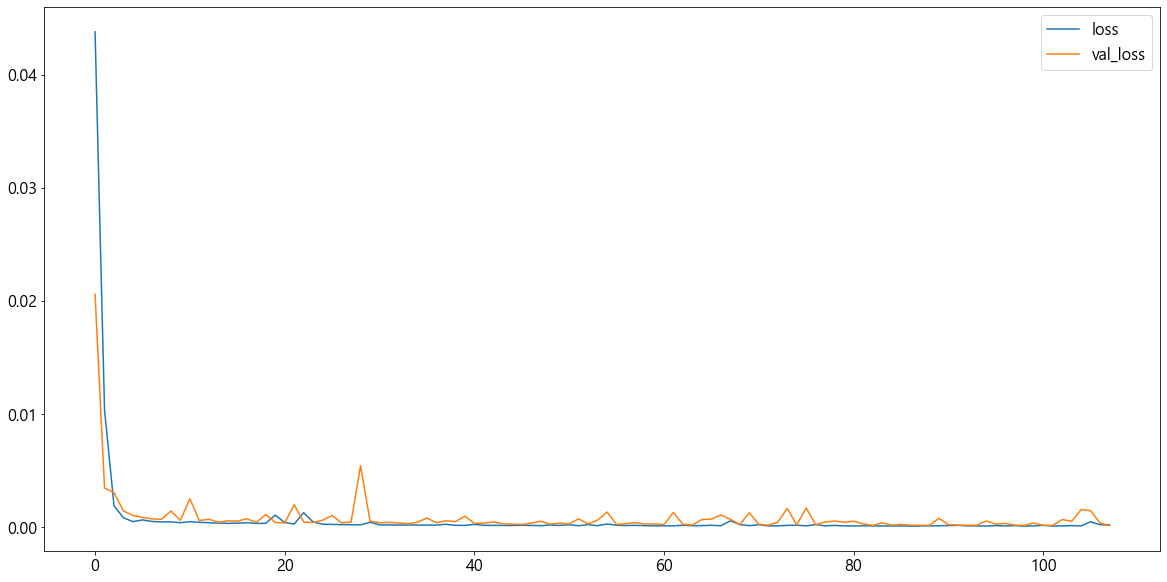

In [ ]:
# 손실률
plt.plot(loss_list[:-50], label='loss')
plt.plot(val_loss_list[:-50], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 모델을 가져온다.
best_model = load_model(path + '/best_model.h5')
best_model


In [ ]:
# # 모델을 가져온다.
# path2 = './model/LSTM/'
# best_model2 = load_model(path2 + '/best_model.h5')
# best_model2

In [ ]:
# 검증데이터를 통해 예측 결과를 가져온다.
pred = best_model.predict(test_data)
pred = pred.reshape(-1)
pred

3/3 [==============================] - 2s 47ms/step


array([0.688987  , 0.6780193 , 0.6744288 , 0.6622635 , 0.65780413,
       0.68932617, 0.6957524 , 0.6958033 , 0.6994393 , 0.6828835 ,
       0.66908383, 0.6684195 , 0.6607467 , 0.6784718 , 0.68120956,
       0.6951958 , 0.70362794, 0.69621336, 0.6993412 , 0.6994393 ,
       0.6821747 , 0.67726076, 0.6729232 , 0.67989457, 0.69640875,
       0.6955602 , 0.6849004 , 0.68337953, 0.66877985, 0.66382873,
       0.6636189 , 0.64795923, 0.6252657 , 0.6202538 , 0.60980284,
       0.61051786, 0.60144305, 0.58769596, 0.58328855, 0.57343495,
       0.5696794 , 0.58192945, 0.59005654, 0.5968034 , 0.5809814 ,
       0.5650286 , 0.5541011 , 0.5635115 , 0.5680754 , 0.5591054 ,
       0.57748735, 0.5890869 , 0.59002185, 0.5805924 , 0.57688963,
       0.5711604 , 0.5993427 , 0.6248679 , 0.6165366 , 0.60781205,
       0.6192558 , 0.6177546 , 0.6139484 , 0.61963665, 0.6227217 ,
       0.6238365 , 0.61812824, 0.61582327, 0.619989  , 0.6172353 ,
       0.6180675 , 0.6185659 , 0.61167896, 0.60224986, 0.59215

In [ ]:
# # 검증데이터를 통해 예측 결과를 가져온다.
# pred2 = best_model2.predict(test_data)
# pred2 = pred2.reshape(-1)
# pred2

In [ ]:
# 원래 결과를 1차원으로 변환한다.
y_test2 = y_test.reshape(-1)
# 20일치를 가지고 21일째를 예측하기 떄문에
# 앞선 20일은 예측하지 않는다.
y_test2 = y_test2[20:]
y_test2

array([0.68087855, 0.67829457, 0.66408269, 0.66149871, 0.69509044,
       0.69379845, 0.69638243, 0.70155039, 0.68346253, 0.67312661,
       0.67312661, 0.6627907 , 0.68346253, 0.68087855, 0.69767442,
       0.70413437, 0.69638243, 0.70284238, 0.70155039, 0.68346253,
       0.68217054, 0.67571059, 0.68346253, 0.69896641, 0.69509044,
       0.68604651, 0.6873385 , 0.67054264, 0.66795866, 0.66666667,
       0.64857881, 0.62661499, 0.62403101, 0.60852713, 0.61111111,
       0.59689922, 0.58268734, 0.58010336, 0.56847545, 0.56589147,
       0.57881137, 0.58397933, 0.59173127, 0.57364341, 0.56072351,
       0.5503876 , 0.5620155 , 0.56330749, 0.55297158, 0.57622739,
       0.58268734, 0.58397933, 0.5749354 , 0.57364341, 0.56718346,
       0.5994832 , 0.62403101, 0.61111111, 0.60594315, 0.62273902,
       0.61627907, 0.61369509, 0.62144703, 0.62273902, 0.62403101,
       0.61757106, 0.61627907, 0.62144703, 0.61627907, 0.61886305,
       0.61886305, 0.60981912, 0.5994832 , 0.5878553 , 0.59819

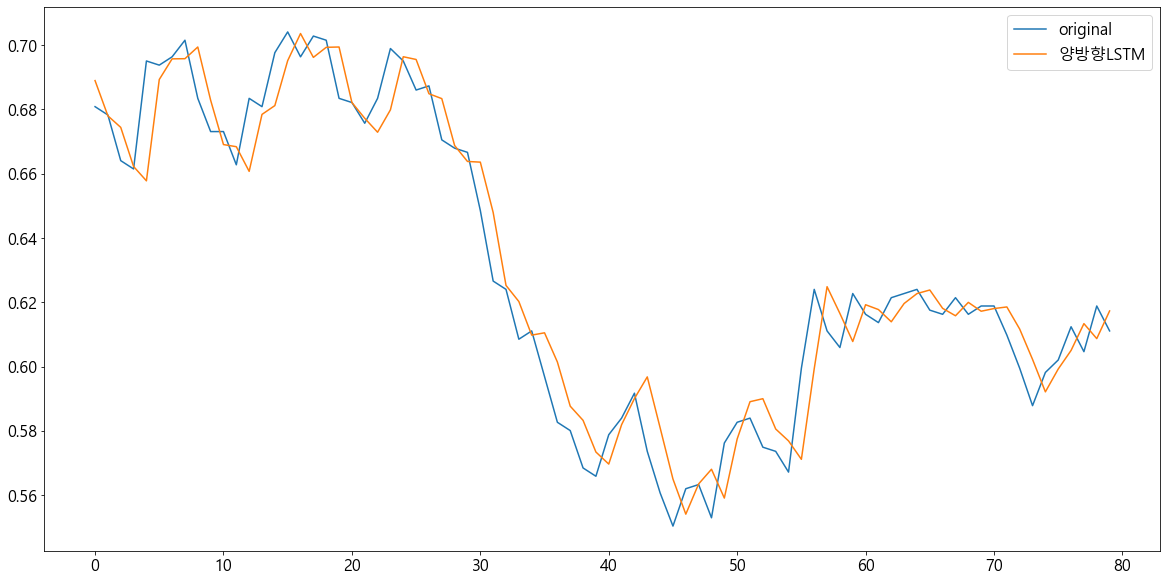

In [ ]:
# 양방향 LSTM
plt.plot(y_test2, label = 'original')
plt.plot(pred, label='양방향LSTM')
# plt.plot(pred2, label='LSTM')
# plt.xticks(cell.index)
plt.legend()
plt.show()